# Check Volatility and MA relationship

Correlation coefficient: 0.999530510582934


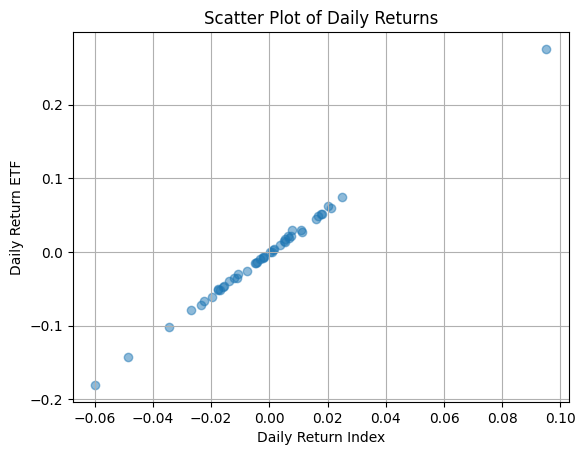

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset with the data you want to compute the volatility and MA for
file_path = "SPX and SPXL.xlsx"

# Load the "Combined" sheet
df = pd.read_excel(file_path, sheet_name="Tariffs") #Change according to period needed

# Ensure the date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Calculate returns for Index and ETF
df['returnsIndex'] = df['SPX Price'].pct_change()
df['returnsETF'] = df['SPXL ETF Price'].pct_change()

correlation = df['returnsIndex'].corr(df['returnsETF'])
print("Correlation coefficient:", correlation)

# Optionally, create a scatter plot to visualize the relationship
plt.scatter(df['returnsIndex'], df['returnsETF'], alpha=0.5)
plt.xlabel('Daily Return Index')
plt.ylabel('Daily Return ETF')
plt.title('Scatter Plot of Daily Returns')
plt.grid(True)
plt.show()

Average Volatility for periods above and below the Moving Average:
   MA_Window  Avg_Volatility_Above  Avg_Volatility_Below
0         10              0.025211              0.084207
1         20              0.030448              0.063772
2         50                   NaN              0.066098
3        100                   NaN              0.066098
4        200                   NaN              0.066098


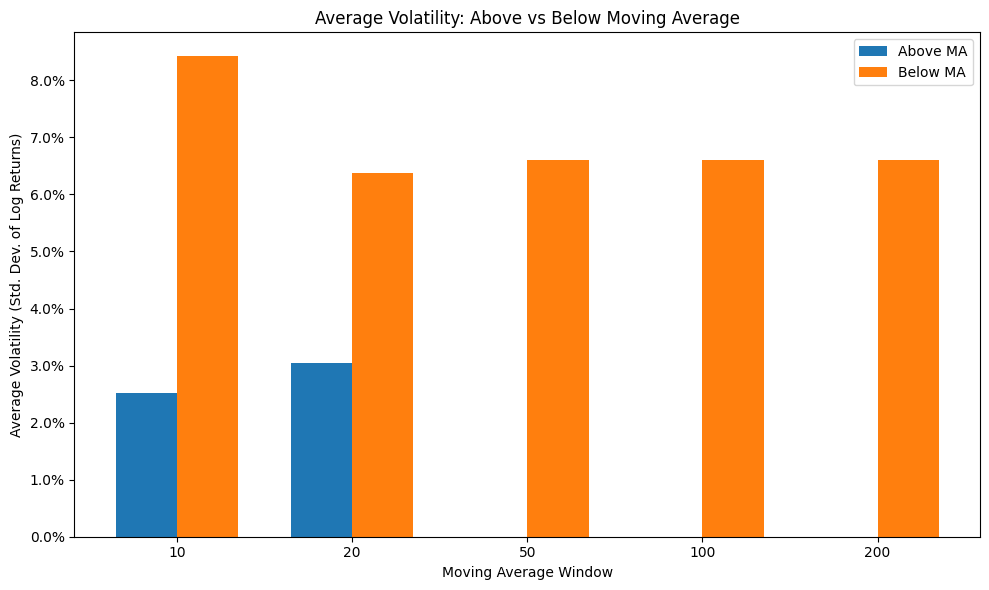

In [2]:
import matplotlib.ticker as mtick

# Calculate log returns (volatility proxy)
df['log_return'] = np.log(df['SPXL ETF Price']).diff()

# Define the moving average windows
ma_windows = [10, 20, 50, 100, 200]

# Initialize a list to store results
results = []

# Loop through each moving average window (RMB to change the Price column name with different datasets)
for ma in ma_windows:
    ma_col = f'MA_{ma}'
    signal_col = f'signal_{ma}'
    group_col = f'group_{ma}'
    
    # Compute the moving average
    df[ma_col] = df['SPXL ETF Price'].rolling(window=ma).mean()
    
    # Create a signal: 1 if Price > MA, 0 otherwise
    df[signal_col] = np.where(df['SPXL ETF Price'] > df[ma_col], 1, 0)
    
    #Identify contiguous segments where the signal is constant.
    #Each time the signal changes, we increment the group number.
    df[group_col] = (df[signal_col] != df[signal_col].shift(1)).cumsum()
    
    #Group by the contiguous segments (ignoring the first row with NaN returns)
    groups = df.dropna(subset=['log_return']).groupby(group_col)
    
    #For each group, calculate the volatility (standard deviation of log returns)
    #and note whether the segment was above (1) or below (0) the MA.
    group_stats = groups.agg({'log_return': 'std', signal_col: 'first'})
    group_stats.rename(columns={'log_return': 'volatility', signal_col: 'signal'}, inplace=True)
    
    #Calculate average volatility for periods where the price is above and below the MA
    avg_vol_above = group_stats[group_stats['signal'] == 1]['volatility'].mean()
    avg_vol_below = group_stats[group_stats['signal'] == 0]['volatility'].mean()
    
    results.append({
        'MA_Window': ma, 
        'Avg_Volatility_Above': avg_vol_above, 
        'Avg_Volatility_Below': avg_vol_below
    })

#Create a table (DataFrame) from the results
result_df = pd.DataFrame(results)
print("Average Volatility for periods above and below the Moving Average:")
print(result_df)

#Plotting the results: grouped bar chart comparing above vs below MA volatility for each MA window.
x = np.arange(len(ma_windows))  #positions for each MA window
width = 0.35  #width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars_above = ax.bar(x - width/2, result_df['Avg_Volatility_Above'], width, label='Above MA')
bars_below = ax.bar(x + width/2, result_df['Avg_Volatility_Below'], width, label='Below MA')

ax.set_xlabel('Moving Average Window')
ax.set_ylabel('Average Volatility (Std. Dev. of Log Returns)')
ax.set_title('Average Volatility: Above vs Below Moving Average')
ax.set_xticks(x)
ax.set_xticklabels(ma_windows)
ax.legend()

#Percentage format
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

Average Annualized Volatility for periods above and below the Moving Average:
   MA_Window  Avg_Annualized_Vol_Above  Avg_Annualized_Vol_Below
0         10                  0.400217                  1.336743
1         20                  0.483351                  1.012344
2         50                       NaN                  1.049273
3        100                       NaN                  1.049273
4        200                       NaN                  1.049273


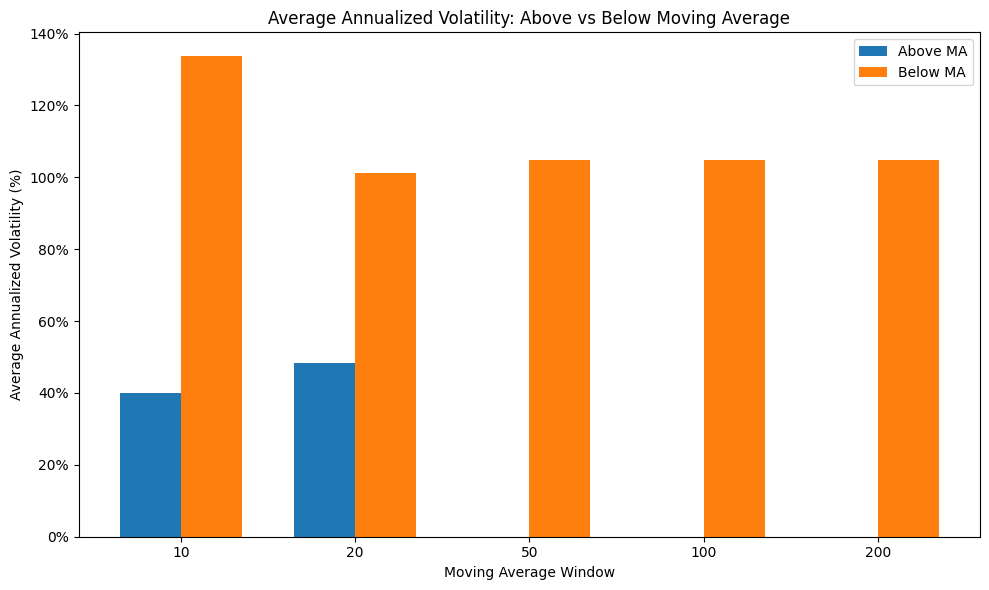

In [3]:
#To see annualized volatility
#Calculate log returns (volatility proxy)
df['log_return'] = np.log(df['SPXL ETF Price']).diff()

#Define the moving average windows
ma_windows = [10, 20, 50, 100, 200]

#Annualization factor (assuming daily returns, 252 trading days in a year)
annualization_factor = np.sqrt(252)

#Initialize a list to store results
results = []

#Loop through each moving average window
for ma in ma_windows:
    ma_col = f'MA_{ma}'
    signal_col = f'signal_{ma}'
    group_col = f'group_{ma}'
    
    #Compute the moving average
    df[ma_col] = df['SPXL ETF Price'].rolling(window=ma).mean()
    
    #Create a signal: 1 if Price > MA, 0 otherwise
    df[signal_col] = np.where(df['SPXL ETF Price'] > df[ma_col], 1, 0)
    
    #Identify contiguous segments where the signal is constant.
    df[group_col] = (df[signal_col] != df[signal_col].shift(1)).cumsum()
    
    #Group by these segments (ignoring the first row with NaN returns)
    groups = df.dropna(subset=['log_return']).groupby(group_col)
    
    #For each group, calculate the volatility (std dev of log returns)
    #and record whether the segment was above (1) or below (0) the MA.
    group_stats = groups.agg({'log_return': 'std', signal_col: 'first'})
    group_stats.rename(columns={'log_return': 'volatility', signal_col: 'signal'}, inplace=True)
    
    #Annualize the volatility by multiplying by sqrt(252)
    group_stats['annualized_vol'] = group_stats['volatility'] * annualization_factor
    
    #Calculate average annualized volatility for periods where the price is above and below the MA
    avg_vol_above = group_stats[group_stats['signal'] == 1]['annualized_vol'].mean()
    avg_vol_below = group_stats[group_stats['signal'] == 0]['annualized_vol'].mean()
    
    results.append({
        'MA_Window': ma, 
        'Avg_Annualized_Vol_Above': avg_vol_above, 
        'Avg_Annualized_Vol_Below': avg_vol_below
    })

#Create a table (DataFrame) from the results
result_df = pd.DataFrame(results)
print("Average Annualized Volatility for periods above and below the Moving Average:")
print(result_df)

#Plotting the results: grouped bar chart comparing above vs below MA annualized volatility for each MA window.
x = np.arange(len(ma_windows))  #positions for each MA window
width = 0.35  #width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars_above = ax.bar(x - width/2, result_df['Avg_Annualized_Vol_Above'], width, label='Above MA')
bars_below = ax.bar(x + width/2, result_df['Avg_Annualized_Vol_Below'], width, label='Below MA')

ax.set_xlabel('Moving Average Window')
ax.set_ylabel('Average Annualized Volatility (%)')
ax.set_title('Average Annualized Volatility: Above vs Below Moving Average')
ax.set_xticks(x)
ax.set_xticklabels(ma_windows)
ax.legend()

#Format the y-axis to display percentages.
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

# Implementation of Strategy

In [4]:
# Parameters
initial_investment = 1000
transaction_cost = 0.005  # per share
slippage = 0.001          # as a % of price
stop_loss_percent = 0.10  # fixed 10% stop loss for trailing stop

# Walk forward settings
window_test = 252
step = window_test

DEBUG = False  # Toggle debug output

#Fucntions
def run_segment(segment, starting_value, ma):
    """
    Run the trading simulation on one segment.
    Returns the updated segment (with Portfolio_Value, Signal, etc.) and the ending portfolio value.
    """
    segment = segment.copy()
    # Initialize portfolio value column
    segment['Portfolio_Value'] = np.nan
    segment.at[segment.index[0], 'Portfolio_Value'] = starting_value

    segment['Signal'] = 0         # 1=Buy, 0=Hold, -1=Sell
    segment['Trade_Price'] = np.nan
    segment['Trailing_Stop'] = np.nan
    segment['Trade_PnL'] = np.nan # New column for trade PnL

    # Initialize state variables
    in_trade = False
    pending_buy = False
    pending_buy_idx = None
    pending_exit = False
    pending_exit_idx = None
    trade_price = 0
    shares_held = 0
    trailing_stop = 0
    entry_date = None
    cash_on_hand = 0
    hold_period = 3  # days to hold before considering MA exit
    entry_portfolio_value = None #Entry

    # Loop over each row in the segment
    for i in range(len(segment)):
        current_date = segment['Date'].iloc[i]
        current_open = segment['SPXL ETF Open'].iloc[i]
        current_close = segment['SPXL ETF Price'].iloc[i]
        current_low = segment['SPXL ETF Low'].iloc[i]
        current_high = segment['SPXL ETF High'].iloc[i]

        if DEBUG:
            print(f"\nIndex {i}, Date: {current_date}")
            print(f"Open: {current_open}, Close: {current_close}, Low: {current_low}, High: {current_high}")

        #Execute pending buy order
        if pending_buy:
            # Use previous portfolio value to determine current notional
            current_notional = segment.at[segment.index[i-1], 'Portfolio_Value'] if i > 0 else starting_value
            entry_portfolio_value = current_notional
            trade_price = current_open + transaction_cost + (current_open * slippage) # next day's open
            shares_held = current_notional / trade_price
            trailing_stop = trade_price * (1 - stop_loss_percent)
            entry_date = segment['Date'].iloc[pending_buy_idx]
            segment.at[segment.index[i], 'Signal'] = 1
            segment.at[segment.index[i], 'Trade_Price'] = trade_price
            in_trade = True
            pending_buy = False
            if DEBUG:
                print(f"BUY executed at index {i}: trade_price={trade_price}, shares_held={shares_held}, trailing_stop={trailing_stop}")

        #Execute pending exit order
        if pending_exit:
            exit_price = current_close - transaction_cost - (current_close * slippage)
            trade_return = (exit_price - trade_price) / trade_price
            segment.at[segment.index[i], 'Signal'] = -1
            segment.at[segment.index[i], 'Trade_Price'] = exit_price
            segment.at[segment.index[i], 'Trade_Return'] = trade_return
            final_value = cash_on_hand + (shares_held * exit_price)
            segment.at[segment.index[i], 'Portfolio_Value'] = final_value
            if entry_portfolio_value is not None:
                trade_PnL = final_value - entry_portfolio_value
                segment.at[segment.index[i], 'Trade_PnL'] = trade_PnL
            if DEBUG:
                print(f"SELL executed at index {i}: exit_price={exit_price}, trade_return={trade_return}, final_value={final_value}")
            shares_held = 0
            cash_on_hand = 0
            in_trade = False
            pending_exit = False

        # Signal generation
        if (not in_trade) and (not pending_buy):
            # Buy signal: SPX Open > MA line
            if segment['SPX Price'].iloc[i] > segment[ma].iloc[i]:
                pending_buy = True
                pending_buy_idx = i
                if DEBUG:
                    print(f"Buy signal generated at index {i} for {ma}")

        # In-trade processing
        if in_trade:
            # Update trailing stop based on current high
            trailing_stop = max(trailing_stop, current_high * (1 - stop_loss_percent))
            segment.at[segment.index[i], 'Trailing_Stop'] = trailing_stop

            # Mark-to-market update: recalc portfolio value
            segment.at[segment.index[i], 'Portfolio_Value'] = cash_on_hand + (shares_held * current_close)

            # Exit conditions: stop loss or MA exit after hold period
            if current_low < trailing_stop and not pending_exit:
                pending_exit = True
                pending_exit_idx = i
                if DEBUG:
                    print(f"Stop loss triggered at index {i}")
            elif (entry_date is not None and 
                  (segment['Date'].iloc[i] - entry_date).days >= hold_period and 
                  current_close < segment[ma].iloc[i] * 0.98 and not pending_exit):
                pending_exit = True
                pending_exit_idx = i
                if DEBUG:
                    print(f"MA exit triggered at index {i}")
        else:
            # Not in trade: carry forward previous portfolio value
            segment.at[segment.index[i], 'Portfolio_Value'] = segment.at[segment.index[i-1], 'Portfolio_Value'] if i > 0 else starting_value

    ending_value = segment['Portfolio_Value'].iloc[-1]
    return segment, ending_value

def walk_forward_backtest(df, ma_list):
    """
    Performs walk-forward backtesting for each moving-average (MA).
    Returns a dictionary with keys as MA names and values as the combined simulation results.
    """
    df = df.copy()
    df.sort_values(by='Date', inplace=True)

    results = {}
    for ma in ma_list:
        overall_results_list = []
        current_portfolio_value = initial_investment

        # Loop over segments defined by window_test/step
        for start in range(0, len(df), step):
            end = start + window_test
            segment = df.iloc[start:end].copy()
            if len(segment) == 0:
                break

            seg_result, ending_value = run_segment(segment, current_portfolio_value, ma)
            current_portfolio_value = ending_value  # Propagate portfolio value to next segment
            overall_results_list.append(seg_result)

        overall_results = pd.concat(overall_results_list)
        results[ma] = overall_results

    return results

# Walk-forward backtest execution
ma_list = ['MA_10', 'MA_20', 'MA_50', 'MA_100', 'MA_200']
results = walk_forward_backtest(df, ma_list)
print("Walk-forward backtest completed successfully")

#Inspect results 
print(results['MA_20'][['Date', 'Portfolio_Value', 'Trade_PnL']])

Walk-forward backtest completed successfully
         Date  Portfolio_Value   Trade_PnL
0  2025-02-19      1000.000000         NaN
1  2025-02-20      1000.000000         NaN
2  2025-02-21      1000.000000         NaN
3  2025-02-24      1000.000000         NaN
4  2025-02-25      1000.000000         NaN
5  2025-02-26      1000.000000         NaN
6  2025-02-27      1000.000000         NaN
7  2025-02-28      1000.000000         NaN
8  2025-03-03      1000.000000         NaN
9  2025-03-04      1000.000000         NaN
10 2025-03-05      1000.000000         NaN
11 2025-03-06      1000.000000         NaN
12 2025-03-07      1000.000000         NaN
13 2025-03-10      1000.000000         NaN
14 2025-03-11      1000.000000         NaN
15 2025-03-12      1000.000000         NaN
16 2025-03-13      1000.000000         NaN
17 2025-03-14      1000.000000         NaN
18 2025-03-17      1000.000000         NaN
19 2025-03-18      1000.000000         NaN
20 2025-03-19      1020.929900         NaN
21 2025-0

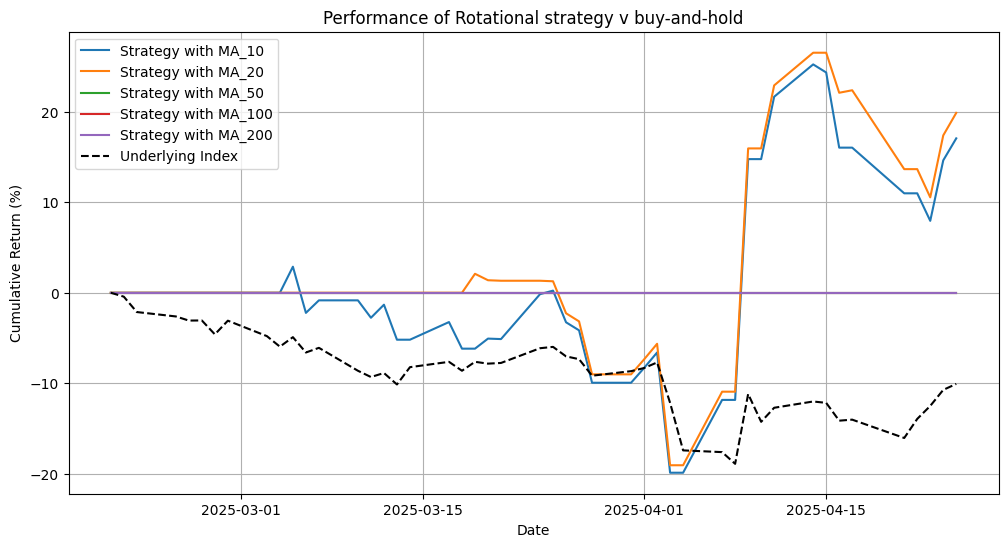

In [5]:
# Calculate cumulative returns for each strategy (if not already calculated)
for ma, df_copy in results.items():
    # Calculate daily returns from portfolio value
    df_copy['Daily_Return'] = df_copy['Portfolio_Value'].pct_change().fillna(0)
    # Calculate cumulative returns: cumulative product of (1 + daily return) minus 1
    df_copy['Cumulative_Return'] = (1 + df_copy['Daily_Return']).cumprod() - 1

# #Write each MA's signals and performance to a separate sheet in the Excel file
# excel_filename = "SPXL_Tariffs_withCosts.xlsx"
# with pd.ExcelWriter(excel_filename) as writer:
#     for ma, df_copy in results.items():
#         # Select columns to output - adjust as needed
#         sheet_df = df_copy[['Date', 'Signal', 'Trade_Price', 'Portfolio_Value','Trade_PnL', 'Daily_Return', 'Cumulative_Return']].copy()
#        #sheet_df = sheet_df[sheet_df['Signal'] != 0] # remove if you want to see the whole time series
#         #Use the moving average as the sheet name (or prefix it if you prefer)
#         sheet_name = f"{ma}"
#         sheet_df.to_excel(writer, sheet_name=sheet_name, index=False)

# print(f"Excel file '{excel_filename}' has been created with a separate sheet for each strategy.")

#Calculating underlying index returns 
df['Index_return'] = df['SPX Price'].pct_change().fillna(0)
df['Index_cum_ret'] = (1 + df['Index_return']).cumprod() - 1

# Plot Cumulative Returns for Each MA Strategy
plt.figure(figsize=(12, 6))
for ma, df_copy in results.items():
    plt.plot(df_copy['Date'], df_copy['Cumulative_Return'] * 100, label=f"Strategy with {ma}")  # multiplied by 100 for percentage display

plt.plot(df['Date'], df['Index_cum_ret'] * 100, label="Underlying Index", color='black', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.title("Performance of Rotational strategy v buy-and-hold")
plt.legend()
plt.grid()
plt.show()

# Performance and Bootstrapped Monte Carlo

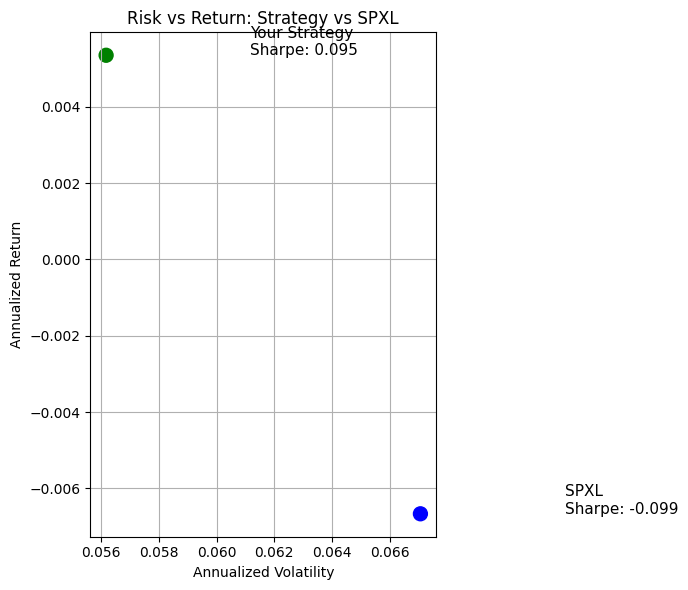

In [6]:
import matplotlib.pyplot as plt

# Data
returns = [0.005353, -0.006667]
vols = [0.05617, 0.06707]
labels = ['Your Strategy', 'SPXL']

# Calculate Sharpe Ratios (rf = 0%)
sharpes = [r / v for r, v in zip(returns, vols)]

# Plot
plt.figure(figsize=(8,6))
plt.scatter(vols, returns, color=['green', 'blue'], s=100)

# Annotate points with label + Sharpe
for i in range(len(labels)):
    label_text = f"{labels[i]}\nSharpe: {sharpes[i]:.3f}"
    plt.text(vols[i]+0.005, returns[i], label_text, fontsize=11)

# Axes
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Risk vs Return: Strategy vs SPXL')
plt.grid(True)
plt.tight_layout()
plt.show()


Median cum-return:       18.12%
5⁄95 percentiles:       -30.85% /  120.64%
P(return > 0):           68.18%


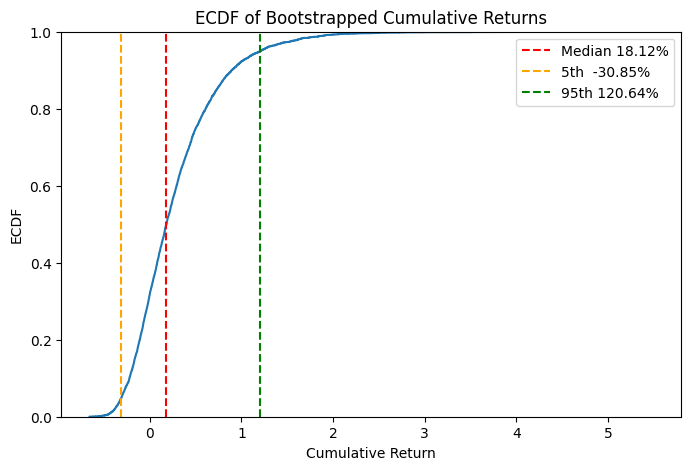

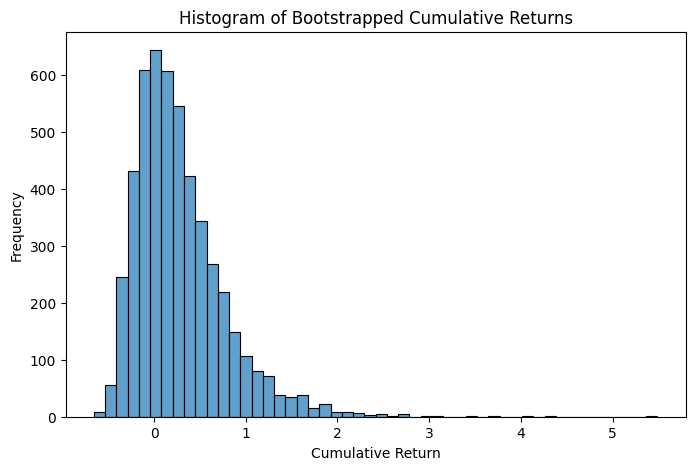

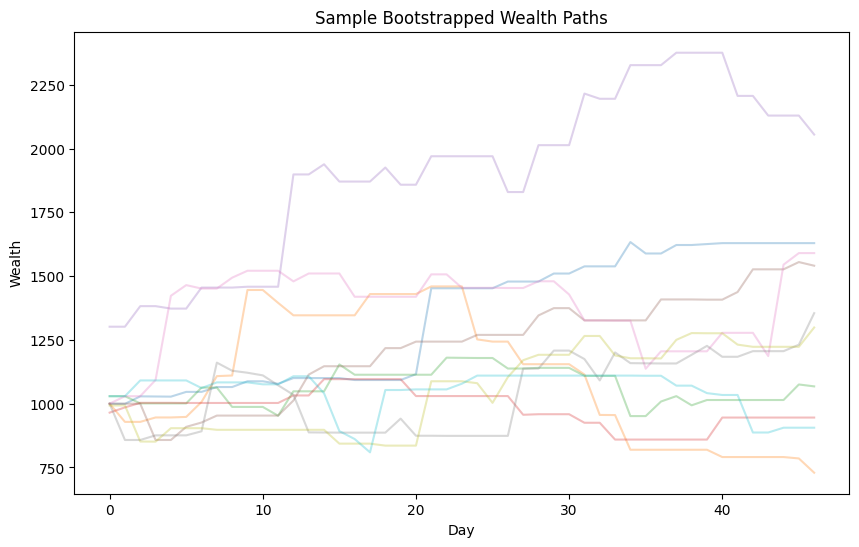

In [7]:
import seaborn as sns

# User inputs / setup
simulated_df       = results['MA_20']
daily_returns      = simulated_df['Daily_Return'].values
n_days             = len(daily_returns)
initial_investment = 1000
n_simulations      = 5000   # ← bump to 10_000 if you like

# Run Monte Carlo
final_values       = np.zeros(n_simulations)
cumulative_returns = np.zeros(n_simulations)

for i in range(n_simulations):
    # resample with replacement
    sim_rets = np.random.choice(daily_returns, size=n_days, replace=True)
    # build wealth path
    wealth   = initial_investment * np.cumprod(1 + sim_rets)
    final_values[i]       = wealth[-1]
    cumulative_returns[i] = (wealth[-1] / initial_investment) - 1

# Compute summary stats
median_ret      = np.median(cumulative_returns)
p5, p95         = np.percentile(cumulative_returns, [5, 95])
prob_pos        = np.mean(cumulative_returns > 0)

print(f"Median cum-return:      {median_ret: .2%}")
print(f"5⁄95 percentiles:       {p5: .2%} / {p95: .2%}")
print(f"P(return > 0):          {prob_pos: .2%}")

#save to Excel (optional)
# excel_filename = "SPXL_Tariff_MC_MA20.xlsx"
# monte_carlo_df = pd.DataFrame({
#     'Final_Value': final_values,
#     'Cumulative_Return': cumulative_returns
# })
# with pd.ExcelWriter(excel_filename, mode='a') as writer:
#     monte_carlo_df.to_excel(writer, sheet_name='MC_Details', index=False)

# ECDF of cumulative returns
plt.figure(figsize=(8, 5))
sns.ecdfplot(cumulative_returns)
plt.axvline(median_ret, color='red',   linestyle='--', label=f"Median {median_ret:.2%}")
plt.axvline(p5,         color='orange',linestyle='--', label=f"5th  {p5:.2%}")
plt.axvline(p95,        color='green', linestyle='--', label=f"95th {p95:.2%}")
plt.xlabel("Cumulative Return")
plt.ylabel("ECDF")
plt.title("ECDF of Bootstrapped Cumulative Returns")
plt.legend()
plt.show()

# Histogram of cumulative returns
plt.figure(figsize=(8, 5))
sns.histplot(cumulative_returns, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel("Cumulative Return")
plt.ylabel("Frequency")
plt.title("Histogram of Bootstrapped Cumulative Returns")
plt.show()

# Sample wealth paths 
plt.figure(figsize=(10, 6))
for idx in np.random.choice(n_simulations, size=10, replace=False):
    sim_rets = np.random.choice(daily_returns, size=n_days, replace=True)
    path      = initial_investment * np.cumprod(1 + sim_rets)
    plt.plot(path, alpha=0.3)
plt.xlabel("Day")
plt.ylabel("Wealth")
plt.title("Sample Bootstrapped Wealth Paths")
plt.show()
